In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Load Dataset

In [2]:
dataset=pd.read_csv('spam.csv',encoding="ISO-8859-1")

In [3]:
dataset.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
dataset.shape

(5572, 2)

In [5]:
dataset.isna().sum()

v1    0
v2    0
dtype: int64

In [6]:
dataset.rename(columns={'v1':'label','v2':'text'},inplace=True)

In [7]:
dataset.columns

Index(['label', 'text'], dtype='object')

<Axes: xlabel='label'>

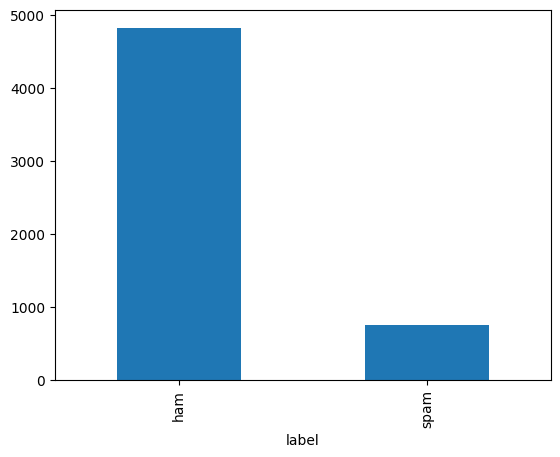

In [8]:
dataset['label'].value_counts().plot(kind='bar')

In [9]:
dataset['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

# Remove special numbers, and extra spaces and "Stopwords".

In [10]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
all_stopwords=stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vishn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def convert(text):
    text=text.lower()
    text=re.sub(r'\d+','',text)
    text=re.sub(r'[^a-z\s,\.!?]',' ',text)
    text=re.sub(r'\s+',' ',text)

    words=text.split()
    flatten_words=[]
    for word in words:
        if word not in all_stopwords:
            flatten_words.append(word)
    return ' '.join(word for word in flatten_words)

In [12]:
dataset['text']=dataset['text'].apply(convert)

In [13]:
dataset['text'][9]

'mobile months more? u r entitled update latest colour mobiles camera free! call mobile update co free'

# Apply lemmatization to get the base form of words.

In [14]:
import spacy

C:\Users\vishn\AppData\Roaming\Python\Python311\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [15]:
nlp=spacy.load('en_core_web_md',disable=['parser','ner'])

In [16]:
def convert_lemmatize(text):
    sentance_word_list=nlp.pipe(text,batch_size=200)
    lemmatize=[]
    for each_sentance_list in sentance_word_list:
        lemmatize_sentance=""
        for word in each_sentance_list:
            if word.is_punct:
                lemmatize_sentance=lemmatize_sentance.rstrip()+word.text+" "
            else:
                lemmatize_sentance+=word.lemma_+" "
        lemmatize.append(lemmatize_sentance)
    return lemmatize

In [17]:
dataset['text']=convert_lemmatize(dataset['text'])

In [18]:
dataset['text'][10]

'go to home soon want talk stuff anymore tonight, k? cry enough today. '

# Word2Vec and Embedding

In [19]:
import gensim
from gensim.models import Word2Vec

In [20]:
# 1. Prepare the data as list of words (tokenized sentences)
sentences = [text.split() for text in dataset['text']]

In [21]:
# 2. Train Word2Vec model
word2vec_model = Word2Vec(
    sentences,        # tokenized sentences
    vector_size=100,  # size of the word vectors
    window=5,         # context window
    min_count=1,      # ignore words with total frequency < 1
    workers=4,        # parallel threads
    sg=1              # skip-gram (1) or CBOW (0)
)

In [22]:
# 3. Get vector for each word
word_vectors = word2vec_model.wv

In [23]:
# 4. Convert each sentence to a sequence of vectors
padded_sequences = []
max_len = 30  # same as before
for sentence in sentences:
    vecs = [word_vectors[word] for word in sentence if word in word_vectors]
    # Padding/truncating
    if len(vecs) < max_len:
        vecs.extend([[0]*100]*(max_len - len(vecs)))  # zero-padding
    else:
        vecs = vecs[:max_len]
    padded_sequences.append(vecs)

In [24]:
padded_sequences = np.array(padded_sequences)
print("Shape of Word2Vec padded sequences:", padded_sequences.shape)

Shape of Word2Vec padded sequences: (5572, 30, 100)


In [25]:
padded_sequences[0]

array([[-0.2030254 ,  0.07116912,  0.14132437, ..., -0.22383903,
        -0.0908896 , -0.02086092],
       [-0.01106544,  0.01457258, -0.00198883, ..., -0.02577834,
         0.00706036,  0.00379996],
       [-0.01835158,  0.0126149 ,  0.01248608, ..., -0.0092983 ,
         0.00948727,  0.00101481],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# Splitting dataset

In [26]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
labels=le.fit_transform(dataset['label'])

In [27]:
labels

array([0, 0, 1, ..., 0, 0, 0])

In [28]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

# Flatten 3D sequences to 2D
num_samples, max_len, vec_size = padded_sequences.shape
padded_flat = padded_sequences.reshape(num_samples, max_len*vec_size)

ros = RandomOverSampler()
padded_flat_resampled, labels_resampled = ros.fit_resample(padded_flat, labels)

# Convert back to 3D if needed
padded_sequences_resampled = padded_flat_resampled.reshape(-1, max_len, vec_size)

# Convert labels to Pandas Series to use value_counts
labels_resampled = pd.Series(labels_resampled)
print(labels_resampled.value_counts())


0    4825
1    4825
Name: count, dtype: int64


<Axes: >

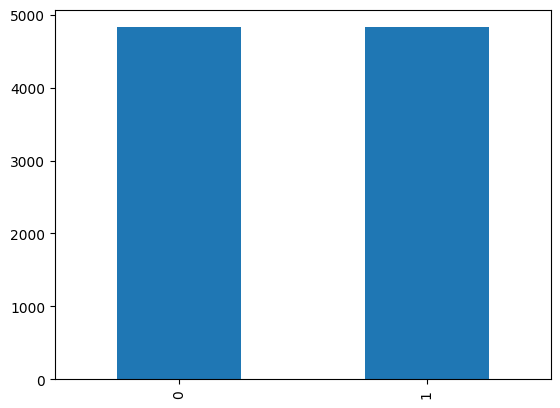

In [29]:
labels_resampled.value_counts().plot(kind='bar')

In [30]:
from sklearn.model_selection import train_test_split
import numpy as np

# Convert labels to NumPy array
labels_resampled = np.array(labels_resampled)

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(
    padded_sequences_resampled, 
    labels_resampled, 
    test_size=0.2, 
    random_state=10
)

print("Training data shape:", x_train.shape)
print("Validation data shape:", x_valid.shape)


Training data shape: (7720, 30, 100)
Validation data shape: (1930, 30, 100)


# Deep Learning Model Selection

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Input

In [32]:
lstm_units = 64
dropout_rate = 0.3
input_shape = (padded_sequences_resampled.shape[1], padded_sequences_resampled.shape[2])  # (max_len, vec_size)


In [33]:
model = Sequential([
    Input(shape=input_shape),
    Bidirectional(LSTM(lstm_units, return_sequences=True)),
    Dropout(dropout_rate),
    LSTM(lstm_units),
    Dropout(dropout_rate),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [34]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_r = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)


In [36]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    epochs=50,
    batch_size=32,
    callbacks=[earlystopping, reduce_r]
)

Epoch 1/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.8718 - loss: 0.3375 - val_accuracy: 0.9332 - val_loss: 0.1767 - learning_rate: 0.0010
Epoch 2/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9299 - loss: 0.1804 - val_accuracy: 0.9389 - val_loss: 0.1757 - learning_rate: 0.0010
Epoch 3/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9461 - loss: 0.1628 - val_accuracy: 0.9420 - val_loss: 0.1691 - learning_rate: 0.0010
Epoch 4/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9430 - loss: 0.1572 - val_accuracy: 0.9316 - val_loss: 0.1830 - learning_rate: 0.0010
Epoch 5/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9524 - loss: 0.1475 - val_accuracy: 0.9472 - val_loss: 0.1513 - learning_rate: 0.0010
Epoch 6/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9463 - loss: 0.1481 - val_accuracy: 0.9394 - val_loss: 0.1540 - learning_rate: 0.0010
Epoch 7/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9408 - loss

# Saving a model

In [40]:
model.save('spam_mail_model.h5')

In [41]:
import pickle
with open('stopwords.pkl','wb') as file:
    pickle.dump(all_stopwords,file)

In [43]:
preprocessing = {
    'word2vec_model': word2vec_model,  # Word2Vec model
    'max_length': max_len,             # max sequence length
    'label_encoder': le,               # LabelEncoder
    'nlp': nlp                         # NLP object for lemmatization
}

# Save all preprocessing objects
with open('preprocessing.pkl', 'wb') as file:
    pickle.dump(preprocessing, file)